In [1]:
#setup
bucket = 'baby-data'

import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

import numpy as np
import pandas as pd
import sagemaker
from sagemaker.predictor import csv_serializer 

from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt   

s3 = boto3.client('s3') 
obj = s3.get_object(Bucket = bucket, Key = 'mergedData.csv') 

data = pd.read_csv(obj['Body'])

numberOfBabies = data['id'].nunique()

pred_data = pd.DataFrame(columns=['actual', 'predicted'])

In [2]:
#babyNum = 1
babyNum = 6
pred_data = pd.read_csv('./pred_data.csv')

while babyNum <= numberOfBabies:
    # hold out one baby's data for testing
    test_data = data.loc[data['id'] == babyNum]
    test_data = test_data.drop(['id'], axis=1)
    test_data = test_data.reset_index(drop=True)
    
    # separate the rest of the data into training and validation
    train_data = pd.DataFrame(columns=data.columns)
    validation_data = pd.DataFrame(columns=data.columns)
    
    innerBabyNum = 1
    while innerBabyNum <= numberOfBabies:
        if innerBabyNum == babyNum:
            innerBabyNum = innerBabyNum + 1
        else:
            innerBabyData = data.loc[data['id'] == innerBabyNum]
            innerBabyData = innerBabyData.reset_index(drop=True)
            train, validation = np.split(innerBabyData, [int(0.7*len(innerBabyData))])    
            train_data = train_data.append(train)
            validation_data = validation_data.append(validation)        
            innerBabyNum = innerBabyNum + 1
    validation_data = validation_data.drop(['id'], axis=1)
    train_data = train_data.drop(['id'], axis=1)
    
    train_data.to_csv('train.csv', index=False, header=False)
    validation_data.to_csv('validation.csv', index=False, header=False)

    # copy the file to S3
    boto3.Session().resource('s3').Bucket(bucket).Object('train/train.csv').upload_file('train.csv')
    boto3.Session().resource('s3').Bucket(bucket).Object('validation/validation.csv').upload_file('validation.csv')
    boto3.Session().resource('s3').Bucket(bucket).Object('test/test.csv').upload_file('test.csv')

    container = get_image_uri(boto3.Session().region_name, 'xgboost')

    s3_input_train = sagemaker.s3_input(s3_data = 's3://{}/train'.format(bucket), content_type = 'csv')
    s3_input_validation = sagemaker.s3_input(s3_data = 's3://{}/validation'.format(bucket), content_type = 'csv')

    # train
    sess = sagemaker.Session()

    xgb = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count=1,
                                       train_instance_type='ml.m4.xlarge',
                                       output_path='s3://{}/output'.format(bucket),
                                       sagemaker_session=sess)
    xgb.set_hyperparameters(objective='binary:logistic', 
                            eval_metric='error',
                            alpha=1.5,
                            eta=.05,
                            max_depth=8,
                            min_child_weight=3.7,
                            num_round=100
                           )

    xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    # evaluate model
    xgb_predictor = xgb.deploy(initial_instance_count=1,
                               instance_type='ml.m4.xlarge')

    xgb_predictor.content_type = 'text/csv'
    xgb_predictor.serializer = csv_serializer
    xgb_predictor.deserializer = None

    def predict(data, rows=500):
        split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
        predictions = ''
        for array in split_array:
            predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

        return np.fromstring(predictions[1:], sep=',')

    predictions = predict(test_data.as_matrix()[:, 1:])
    
    # concat actual data and prediction
    predictionDF = pd.DataFrame(data=predictions)
    addData = pd.concat([test_data['CSGM'], predictionDF], axis=1, ignore_index=True)
    addData = addData.rename(columns={0: "actual", 1: "predicted"})
    
    # add to pred_data
    pred_data = pred_data.append(addData)
    
    # delete endpoint
    sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
    
    print(babyNum)
    babyNum = babyNum + 1

INFO:sagemaker:Creating training-job with name: xgboost-2019-02-20-00-49-09-509


2019-02-20 00:49:09 Starting - Starting the training job...
2019-02-20 00:49:10 Starting - Launching requested ML instances......
2019-02-20 00:50:15 Starting - Preparing the instances for training......
2019-02-20 00:51:35 Downloading - Downloading input data...
2019-02-20 00:52:09 Training - Training image download completed. Training in progress..
Arguments: train
[2019-02-20:00:52:09:INFO] Running standalone xgboost training.
[2019-02-20:00:52:09:INFO] File size need to be processed in the node: 587.67mb. Available memory size in the node: 8417.24mb
[2019-02-20:00:52:09:INFO] Determined delimiter of CSV input is ','
[00:52:09] S3DistributionType set as FullyReplicated
[00:52:11] 399381x84 matrix with 33548004 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-20:00:52:11:INFO] Determined delimiter of CSV input is ','
[00:52:11] S3DistributionType set as FullyReplicated
[00:52:12] 171170x84 matrix with 14378280 entries loaded from /opt/ml/inp

[00:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[40]#011train-error:0.014535#011validation-error:0.067372
[00:54:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[41]#011train-error:0.014477#011validation-error:0.067354
[00:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[42]#011train-error:0.014307#011validation-error:0.067348
[00:54:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[43]#011train-error:0.01425#011validation-error:0.067313
[00:54:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[44]#011train-error:0.014255#011validation-error:0.067337
[00:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[45]#011train-error:0.014187#011v

[00:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[86]#011train-error:0.01115#011validation-error:0.067009
[00:56:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[87]#011train-error:0.011117#011validation-error:0.067009
[00:56:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[88]#011train-error:0.011067#011validation-error:0.067009
[00:56:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[89]#011train-error:0.011007#011validation-error:0.067009
[00:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[90]#011train-error:0.011002#011validation-error:0.067004
[00:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[91]#011train-error:0.010922#011v

INFO:sagemaker:Creating model with name: xgboost-2019-02-20-00-57-54-333


Billable seconds: 346


INFO:sagemaker:Creating endpoint with name xgboost-2019-02-20-00-49-09-509


---------------------------------------------------------------------------!

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-02-20-00-49-09-509


6


INFO:sagemaker:Creating training-job with name: xgboost-2019-02-20-01-05-42-051


2019-02-20 01:05:42 Starting - Starting the training job...
2019-02-20 01:05:49 Starting - Launching requested ML instances.........
2019-02-20 01:07:24 Starting - Preparing the instances for training......
2019-02-20 01:08:37 Downloading - Downloading input data...
2019-02-20 01:09:12 Training - Training image download completed. Training in progress..
Arguments: train
[2019-02-20:01:09:13:INFO] Running standalone xgboost training.
[2019-02-20:01:09:13:INFO] File size need to be processed in the node: 571.23mb. Available memory size in the node: 8408.93mb
[2019-02-20:01:09:13:INFO] Determined delimiter of CSV input is ','
[01:09:13] S3DistributionType set as FullyReplicated
[01:09:15] 388017x84 matrix with 32593428 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-20:01:09:15:INFO] Determined delimiter of CSV input is ','
[01:09:15] S3DistributionType set as FullyReplicated
[01:09:15] 166299x84 matrix with 13969116 entries loaded from /opt/ml/

[01:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[40]#011train-error:0.023321#011validation-error:0.06457
[01:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[41]#011train-error:0.023272#011validation-error:0.06457
[01:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[42]#011train-error:0.023234#011validation-error:0.06457
[01:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[43]#011train-error:0.023115#011validation-error:0.06457
[01:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[44]#011train-error:0.02313#011validation-error:0.064564
[01:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[45]#011train-error:0.023084#011valid

[01:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[84]#011train-error:0.018875#011validation-error:0.064282
[01:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[85]#011train-error:0.018729#011validation-error:0.064282
[01:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[86]#011train-error:0.018662#011validation-error:0.064282
[01:13:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[87]#011train-error:0.01845#011validation-error:0.064276
[01:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[88]#011train-error:0.018448#011validation-error:0.064276
[01:13:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[89]#011train-error:0.018236#011v

INFO:sagemaker:Creating model with name: xgboost-2019-02-20-01-14-57-308


Billable seconds: 357


INFO:sagemaker:Creating endpoint with name xgboost-2019-02-20-01-05-42-051


----------------------------------------------------------------!

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-02-20-01-05-42-051


7


INFO:sagemaker:Creating training-job with name: xgboost-2019-02-20-01-22-03-762


2019-02-20 01:22:03 Starting - Starting the training job...
2019-02-20 01:22:08 Starting - Launching requested ML instances......
2019-02-20 01:23:14 Starting - Preparing the instances for training......
2019-02-20 01:24:26 Downloading - Downloading input data...
2019-02-20 01:25:04 Training - Training image download completed. Training in progress..
Arguments: train
[2019-02-20:01:25:04:INFO] Running standalone xgboost training.
[2019-02-20:01:25:04:INFO] File size need to be processed in the node: 596.59mb. Available memory size in the node: 8420.07mb
[2019-02-20:01:25:04:INFO] Determined delimiter of CSV input is ','
[01:25:04] S3DistributionType set as FullyReplicated
[01:25:06] 405444x84 matrix with 34057296 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-20:01:25:06:INFO] Determined delimiter of CSV input is ','
[01:25:06] S3DistributionType set as FullyReplicated
[01:25:07] 173768x84 matrix with 14596512 entries loaded from /opt/ml/inp

[01:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[40]#011train-error:0.021431#011validation-error:0.074082
[01:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[41]#011train-error:0.021409#011validation-error:0.074128
[01:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[42]#011train-error:0.02132#011validation-error:0.074087
[01:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[43]#011train-error:0.021201#011validation-error:0.074041
[01:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[44]#011train-error:0.021162#011validation-error:0.074024
[01:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[45]#011train-error:0.021071#011v

[01:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[86]#011train-error:0.018138#011validation-error:0.073961
[01:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[87]#011train-error:0.018118#011validation-error:0.073961
[01:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[88]#011train-error:0.017995#011validation-error:0.073949
[01:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[89]#011train-error:0.017874#011validation-error:0.073984
[01:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[90]#011train-error:0.017674#011validation-error:0.073984
[01:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[91]#011train-error:0.017522#011

INFO:sagemaker:Creating model with name: xgboost-2019-02-20-01-30-49-219


Billable seconds: 349


INFO:sagemaker:Creating endpoint with name xgboost-2019-02-20-01-22-03-762


---------------------------------------------------------------!

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-02-20-01-22-03-762


8


INFO:sagemaker:Creating training-job with name: xgboost-2019-02-20-01-37-35-881


2019-02-20 01:37:35 Starting - Starting the training job...
2019-02-20 01:37:36 Starting - Launching requested ML instances......
2019-02-20 01:38:47 Starting - Preparing the instances for training......
2019-02-20 01:39:56 Downloading - Downloading input data...
2019-02-20 01:40:31 Training - Training image download completed. Training in progress..
Arguments: train
[2019-02-20:01:40:32:INFO] Running standalone xgboost training.
[2019-02-20:01:40:32:INFO] File size need to be processed in the node: 570.6mb. Available memory size in the node: 8427.34mb
[2019-02-20:01:40:32:INFO] Determined delimiter of CSV input is ','
[01:40:32] S3DistributionType set as FullyReplicated
[01:40:33] 387601x84 matrix with 32558484 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-20:01:40:33:INFO] Determined delimiter of CSV input is ','
[01:40:33] S3DistributionType set as FullyReplicated
[01:40:34] 166121x84 matrix with 13954164 entries loaded from /opt/ml/inpu

[01:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[38]#011train-error:0.023253#011validation-error:0.080851
[01:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[39]#011train-error:0.023346#011validation-error:0.080851
[01:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[40]#011train-error:0.023351#011validation-error:0.080815
[01:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[41]#011train-error:0.023377#011validation-error:0.080815
[01:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[42]#011train-error:0.023217#011validation-error:0.080809
[01:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[43]#011train-error:0.023127#011

[01:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[84]#011train-error:0.018885#011validation-error:0.080857
[01:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[85]#011train-error:0.018831#011validation-error:0.080857
[01:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[86]#011train-error:0.018795#011validation-error:0.080845
[01:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[87]#011train-error:0.018676#011validation-error:0.080857
[01:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[88]#011train-error:0.018617#011validation-error:0.080857
[01:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[89]#011train-error:0.018565#011

INFO:sagemaker:Creating model with name: xgboost-2019-02-20-01-46-22-869


Billable seconds: 347


INFO:sagemaker:Creating endpoint with name xgboost-2019-02-20-01-37-35-881


--------------------------------------------------------------------------!

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-02-20-01-37-35-881


9


INFO:sagemaker:Creating training-job with name: xgboost-2019-02-20-01-54-08-148


2019-02-20 01:54:08 Starting - Starting the training job...
2019-02-20 01:54:10 Starting - Launching requested ML instances.........
2019-02-20 01:55:44 Starting - Preparing the instances for training......
2019-02-20 01:56:55 Downloading - Downloading input data...
2019-02-20 01:57:29 Training - Training image download completed. Training in progress.
Arguments: train
[2019-02-20:01:57:30:INFO] Running standalone xgboost training.
[2019-02-20:01:57:30:INFO] File size need to be processed in the node: 571.56mb. Available memory size in the node: 8371.85mb
[2019-02-20:01:57:30:INFO] Determined delimiter of CSV input is ','
[01:57:30] S3DistributionType set as FullyReplicated
[01:57:31] 388321x84 matrix with 32618964 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-20:01:57:31:INFO] Determined delimiter of CSV input is ','
[01:57:31] S3DistributionType set as FullyReplicated
[01:57:32] 166430x84 matrix with 13980120 entries loaded from /opt/ml/i

[01:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[38]#011train-error:0.022389#011validation-error:0.081133
[01:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[39]#011train-error:0.022414#011validation-error:0.081115
[01:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[40]#011train-error:0.022327#011validation-error:0.081049
[01:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[41]#011train-error:0.022291#011validation-error:0.081007
[01:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[42]#011train-error:0.022247#011validation-error:0.080995
[01:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[43]#011train-error:0.022234#011

[02:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[84]#011train-error:0.01831#011validation-error:0.080647
[02:01:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[85]#011train-error:0.018256#011validation-error:0.080641
[02:01:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[86]#011train-error:0.018073#011validation-error:0.080659
[02:01:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[87]#011train-error:0.017965#011validation-error:0.080641
[02:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[88]#011train-error:0.017898#011validation-error:0.080628
[02:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[89]#011train-error:0.017859#011v

INFO:sagemaker:Creating model with name: xgboost-2019-02-20-02-02-55-019


Billable seconds: 346


INFO:sagemaker:Creating endpoint with name xgboost-2019-02-20-01-54-08-148


---------------------------------------------------------------!

INFO:sagemaker:Deleting endpoint with name: xgboost-2019-02-20-01-54-08-148


10


In [3]:
# save pred_data to notebook
pred_data.to_csv('pred_data.csv', index=False, header=True)
# boto3.Session().resource('s3').Bucket(bucket).Object('eval/pred_data.csv').upload_file('pred_data.csv')

In [ ]:
## Evaluate predictions from all models

In [4]:
# confusion matrix
pd.crosstab(index=pred_data['actual'], columns=pred_data['predicted'].round(0), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,597913,872
1,25313,16


Validation AUC 0.6831276539092364
Figure(432x288)


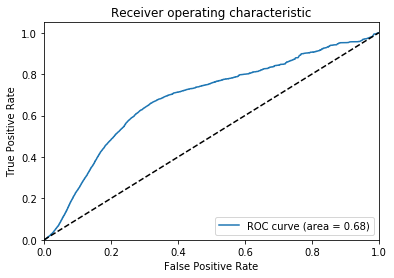

<Figure size 432x288 with 0 Axes>

In [5]:
# ROC-AUC Score
print("Validation AUC", roc_auc_score(list(pred_data['actual']), list(pred_data['predicted'])))
fpr, tpr, thresholds = metrics.roc_curve(list(pred_data['actual']), list(pred_data['predicted']))
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
print(plt.figure())